In [1]:
import pandas as pd
import numpy as np
import pickle
import json

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# files

folder = ''

sims_file = folder+'sims_05.csv'
res_info_folder = folder+'ResInfo/res_info_'
sims_df = pd.read_csv(sims_file)
pickle_files = folder+'specs/'+sims_df['filename']+'.pkl'


filenames = [sims_df['filename'][i] for i in range(len(sims_df))]
res_info_files = [res_info_folder + str(soil_resolution) + '.json' for soil_resolution in sims_df['soil_resolution']]
res_infos = [json.load(open(res_info_file, 'r')) for res_info_file in res_info_files]
sidess = [res_info['sides'] for res_info in res_infos]


filenames = []
n_90 = []
n_95 = []
n_99 = []
n_100 = []
n_total = []

clouds = {
    '90': [],
    '95': [],
    '99': [],
    '100': []
}

cell_portions = []
cell_heatings = []


for i in range(len(sims_df)):

    pickle_file = pickle_files[i]
    soil_resolution = sims_df['soil_resolution'][i]
    res_info_file = res_info_folder + str(soil_resolution) + '.json'
    res_info = json.load(open(res_info_file, 'r'))
    midpoints = np.array(res_info['midpoints'])
    detector_tally_ids = [int(r) for r in res_info['detector_tally_ids']]
    cell_ids = [int(r) for r in res_info['cell_ids']]
    filename = sims_df['filename'][i]
    i_bins, i_spectrums= pickle.load(open(pickle_file, 'rb'))
    detector_energy_bins = i_bins[0][-2]
    detector_spec = i_spectrums[0]
    causal_bins = [str(bin)[:len(str(cell_ids[0]))] for bin in i_bins[4][2]]
    causal_bins = (np.array(causal_bins)).astype(int).tolist()
    causal_energy_bins = i_bins[4][-2]
    causal_spec = i_spectrums[4]
    new_shape = np.array(causal_spec.shape)
    new_shape[2] = len(cell_ids)
    new_array = np.zeros(new_shape)
    for j in range(len(cell_ids)):
        if cell_ids[j] in causal_bins:
            new_array[:, :, j] = causal_spec[:, :, causal_bins.index(cell_ids[j])]
    full_causal_spec = new_array
    cell_heating = full_causal_spec[0, 0, :, 0, 0, 0, :, 0]
    cell_heatings.append(cell_heating)
    total_soil_heating = np.sum(cell_heating, axis=0)
    cells_over_total_heating = np.nan_to_num(np.divide(cell_heating, total_soil_heating), copy=False, nan=0.0, posinf=None, neginf=None)
    cells_over_total_heating = cells_over_total_heating/np.sum(cells_over_total_heating)
    cell_portion = np.sum(cells_over_total_heating, axis=1)

    sorted_indicies = np.argsort(cell_portion)[::-1]
    sorted_vals = (cell_portion)[sorted_indicies]
    def percent_cloud(sorted_indicies, sorted_vals, threshold=0.90):
        total = np.sum(sorted_vals)
        cumulative_sum = np.cumsum(sorted_vals)
        percent = cumulative_sum / total
        return sorted_indicies[percent < threshold]
    cell_portion = np.sum(cells_over_total_heating, axis=1)

    cell_portions.append(cell_portion)

    filenames.append(filename)
    
    cloud_90 = percent_cloud(sorted_indicies, sorted_vals, threshold=.90)
    clouds['90'].append(cloud_90)
    n_90.append(len(cloud_90))

    cloud_95 = percent_cloud(sorted_indicies, sorted_vals, threshold=.95)
    clouds['95'].append(cloud_95)
    n_95.append(len(cloud_95))

    cloud_99 = percent_cloud(sorted_indicies, sorted_vals, threshold=.99)
    clouds['99'].append(cloud_99)
    n_99.append(len(cloud_99))

    cloud_100 = percent_cloud(sorted_indicies, sorted_vals, threshold=1.0)
    clouds['100'].append(cloud_100)
    n_100.append(len(cloud_100))

    n_total.append(len(sorted_indicies))

# cell_heatings = np.array(cell_heatings)

results_df = pd.DataFrame({
    'filename': filenames,
    'n_90': n_90,
    'n_95': n_95,
    'n_99': n_99,
    'n_100': n_100,
    'n_total': n_total
})

clouds_df = pd.DataFrame({
    'filename': filenames,
    'cloud_90': clouds['90'],
    'cloud_95': clouds['95'],
    'cloud_99': clouds['99'],
})

/tmp/ipykernel_68827/1009057201.py:82: RuntimeWarning: invalid value encountered in divide
  cells_over_total_heating = np.nan_to_num(np.divide(cell_heating, total_soil_heating), copy=False, nan=0.0, posinf=None, neginf=None)


In [2]:
len(cell_heatings)

2

In [3]:
cell_portions = [cell_portions[i].tolist() for i in range(len(cell_portions))]
cell_portions = np.array(cell_portions)
cell_portions_df = pd.DataFrame({
    'filename': filenames,
    'cell_portions': [cell_portions[i].tolist() for i in range(len(cell_portions))]
})

In [5]:
cell_heatings_df = pd.DataFrame({
    'filename': filenames,
    'cell_heatings': cell_heatings
})

In [6]:
cell_heatings_df

,filename,cell_heatings
0,9x9x9_C_0060_Feldspar_Fill_003133,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,9x9x9_C_0600_Feldspar_Fill_003142,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [7]:
cell_portions_df

,filename,cell_portions
0,9x9x9_C_0060_Feldspar_Fill_003133,"[1.1027184558172769e-07, 0.0, 0.0, 0.0, 3.3966..."
1,9x9x9_C_0600_Feldspar_Fill_003142,"[0.0, 7.611505872542319e-08, 0.0, 0.0, 1.89818..."


In [10]:
clouds_df

,filename,cloud_90,cloud_95,cloud_99
0,9x9x9_C_0060_Feldspar_Fill_003133,"[377, 368, 449, 287, 458, 296, 376, 359, 367, ...","[377, 368, 449, 287, 458, 296, 376, 359, 367, ...","[377, 368, 449, 287, 458, 296, 376, 359, 367, ..."
1,9x9x9_C_0600_Feldspar_Fill_003142,"[377, 368, 449, 287, 458, 296, 376, 359, 367, ...","[377, 368, 449, 287, 458, 296, 376, 359, 367, ...","[377, 368, 449, 287, 458, 296, 376, 359, 367, ..."


In [11]:
results_df

,filename,n_90,n_95,n_99,n_100,n_total
0,9x9x9_C_0060_Feldspar_Fill_003133,77,125,269,729,729
1,9x9x9_C_0600_Feldspar_Fill_003142,79,129,273,658,729


In [13]:
depth = midpoints[:, 2]
x = midpoints[:, 0]
y = midpoints[:, 1]
depth_prob = cell_heatings_df.iloc[0].cell_heatings.sum(axis=1)

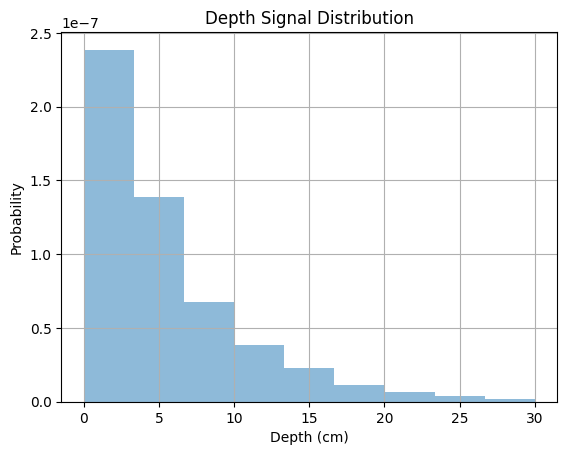

In [17]:
# histogram with depth as bins
hist = plt.hist(-depth, bins=np.sort(-np.array(sidess[0][2])), weights=depth_prob, alpha=0.5)
# plt.plot(hist[1][:-1], hist[0], label='Depth Probability Distribution', color='blue')
plt.xlabel('Depth (cm)')
plt.ylabel('Probability')
plt.title('Depth Signal Distribution')
plt.grid()
plt.show()

In [32]:
hist[0][6:].sum()/hist[0].sum()

np.float64(0.022487224526446595)

In [18]:
1/np.sum(hist[0])

np.float64(1887548.3626319258)

/tmp/ipykernel_68827/1792905684.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


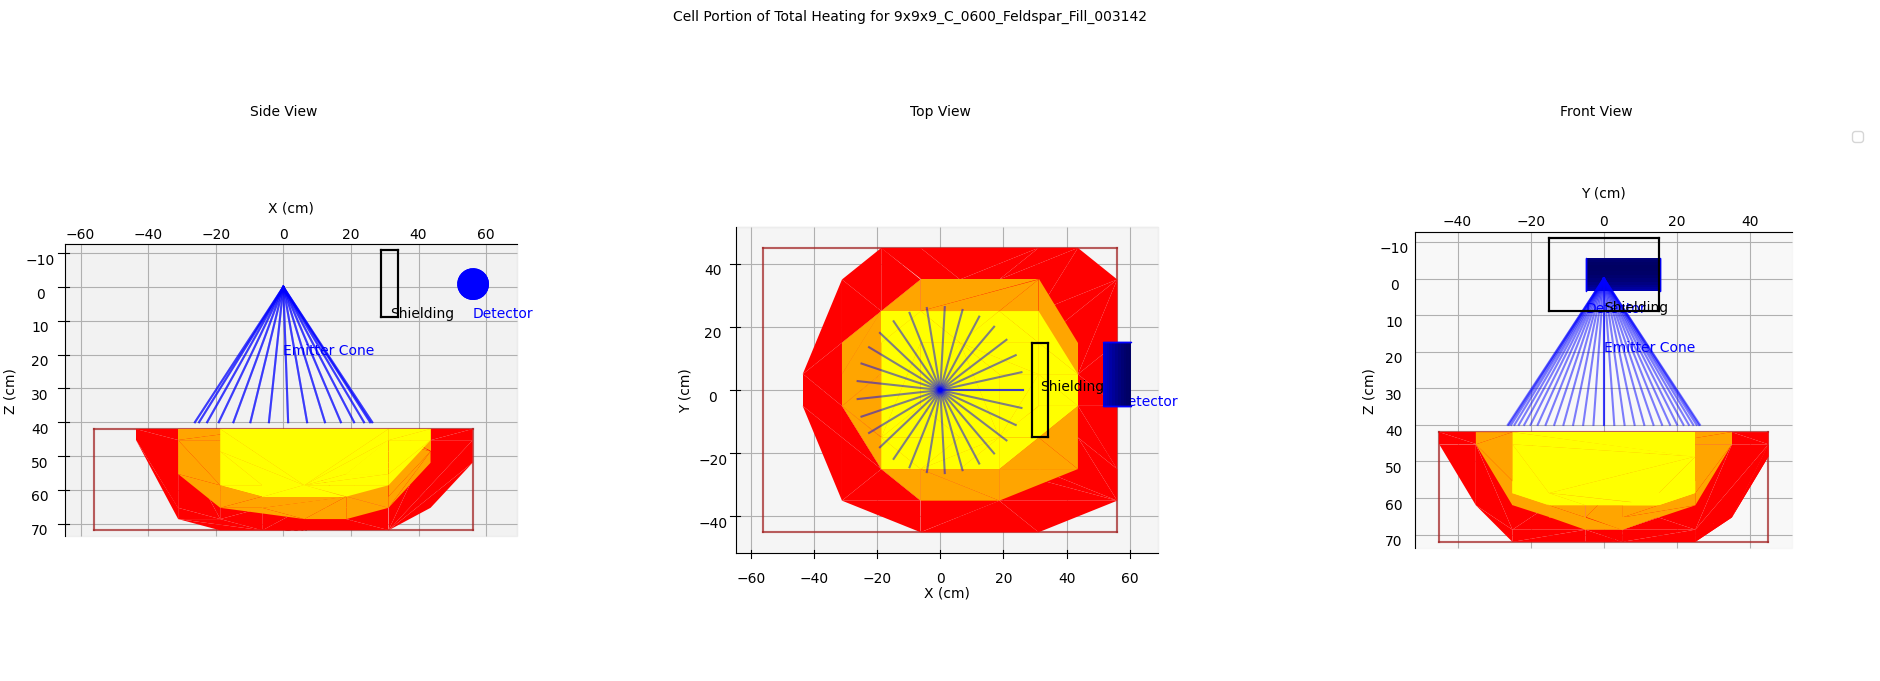

In [21]:
import plotting as pltt


c = 1

def cloud_from_cloud(
        ax0, cloud, filter_mask, 
        alpha=1, 
        color='green',
        zorder=1002,
        ):
    
    cell_mask_vox = pltt.vox_maker(
        cloud, 
        midpoints, 
        cell_portions[c]
        )
    
    cell_mask_vox = cell_mask_vox & filter_mask
    
    pltt.concave_hull(
        ax0, 
        cell_mask_vox, 
        sidess[c], 
        color=color, 
        alpha=alpha,
        zorder=zorder
        )
    

def cloud3(ax, filter_mask):
    cloud_from_cloud(
        ax, 
        clouds['99'][c], 
        filter_mask, 
        alpha=1, 
        color='red',
        zorder=1002,
        )


    cloud_from_cloud(
        ax, 
        clouds['95'][c], 
        filter_mask, 
        alpha=1, 
        color='orange',
        zorder=1002,
        )


    cloud_from_cloud(
        ax, 
        clouds['90'][c], 
        filter_mask, 
        alpha=1, 
        color='yellow',
        zorder=1002,
        )

soil_on_ax = lambda ax: pltt.plot_box(ax, -56, 56, -45, 45, 42, 42+30, color='brown', alpha=.5, label='Soil', zorder=1)

soil_res = [int(s) for s in soil_resolution.split('x')]

fig, axs = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(8*3, 8))
fig.suptitle(f'Cell Portion of Total Heating for {filenames[c]}', fontsize=10)

# side
ax0 = axs[0]
ax0.set_title('Side View', fontsize=10)
soil_on_ax(ax0)
ax0.set_ylim([0, 50])
filter_mask = (midpoints[:, 1]>-0.1).reshape(soil_res)
cloud3(ax0, filter_mask)

pltt.plot_cone(ax0, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='blue', alpha=.5, label='Emitter Cone', zorder=2000)
pltt.plot_cylinder(ax0, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='blue', alpha=1, label='Detector', zorder=200101)
pltt.plot_box(ax0, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
pltt.extra(ax0)
ax0.view_init(elev=0, azim=-90,)
ax0.set_yticklabels([])
ax0.set_yticks([]) 
ax0.set_ylabel('')
ax0.set_aspect('equal')
plt.legend()

# top
ax1 = axs[1]
ax1.set_title('Top View', fontsize=10)
soil_on_ax(ax1)
ax1.set_zlim([42.1, 100])
filter_mask = np.ones(soil_res, dtype=bool)
cloud3(ax1, filter_mask)
pltt.plot_cone(ax1, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='blue', alpha=.5, label='Emitter Cone', zorder=2000)
pltt.plot_cylinder(ax1, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='blue', alpha=1, label='Detector', zorder=200101)
pltt.plot_box(ax1, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
pltt.extra(ax1)
ax1.view_init(elev=90, azim=-90,)
ax1.set_zticklabels([])
ax1.set_zticks([])
ax1.set_zlabel('')
ax1.set_aspect('equal')

# front
ax2 = axs[2]
ax2.set_title('Front View', fontsize=10)
soil_on_ax(ax2)
ax2.set_xlim([-60, 15])
filter_mask = (midpoints[:, 0]<20).reshape(soil_res)
cloud3(ax2, filter_mask)
pltt.plot_cone(ax2, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='blue', alpha=.5, label='Emitter Cone', zorder=2000)
pltt.plot_cylinder(ax2, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='blue', alpha=1, label='Detector', zorder=200101)
pltt.plot_box(ax2, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
pltt.extra(ax2)
ax2.view_init(elev=0, azim=0,)
ax2.set_xticklabels([])
ax2.set_xticks([])
ax2.set_xlabel('')
ax2.set_aspect('equal')